**[CAF-01]** モジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series

np.random.seed(20160531)

**[CAF-02]** トレーニングセットのデータを用意して、20%のデータをテストセットして分離します。

In [2]:
n0, mu0, variance0 = 800, [10, 11], 20
data0 = multivariate_normal(mu0, np.eye(2)*variance0 ,n0)
df0 = DataFrame(data0, columns=['x','y'])
df0['t'] = 0

n1, mu1, variance1 = 600, [18, 20], 22
data1 = multivariate_normal(mu1, np.eye(2)*variance1 ,n1)
df1 = DataFrame(data1, columns=['x','y'])
df1['t'] = 1

df = pd.concat([df0, df1], ignore_index=True)
df = df.reindex(permutation(df.index)).reset_index(drop=True)

num_data = int(len(df)*0.8)
train_set = df[:num_data]
test_set = df[num_data:]

**[CAF-03]** (x, y) と t を別々に集めたものをNumPyのarrayオブジェクトとして取り出しておきます。

In [3]:
### Python3.6でアラートとなるので、下記に修正
train_x = train_set[['x','y']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])
test_x = test_set[['x','y']].values
test_t = test_set['t'].values.reshape([len(test_set), 1])
### 元のソースコード
#train_x = train_set[['x','y']].as_matrix()
#train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])
#test_x = test_set[['x','y']].as_matrix()
#test_t = test_set['t'].as_matrix().reshape([len(test_set), 1])

**[CAF-04]** 各種の計算式を定義します。

In [4]:
x = tf.placeholder(tf.float32, [None, 2])
w = tf.Variable(tf.zeros([2, 1]))
w0 = tf.Variable(tf.zeros([1]))
f = tf.matmul(x, w) + w0
p = tf.sigmoid(f)

t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.AdamOptimizer().minimize(loss)

correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[CAF-05]** セッションを用意して、Variableを初期化します。

In [5]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())

**[CAF-06]** 勾配降下法によるパラメーターの最適化を2500回繰り返しながら、トレーニングセットとテストセットに対する正解率の変化を記録します。

In [6]:
train_accuracy = []
test_accuracy = []
for _ in range(2500):
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    acc_val = sess.run(accuracy, feed_dict={x:train_x, t:train_t})
    train_accuracy.append(acc_val)
    acc_val = sess.run(accuracy, feed_dict={x:test_x, t:test_t})
    test_accuracy.append(acc_val)

**[CAF-07]** 結果をグラフに表示します。

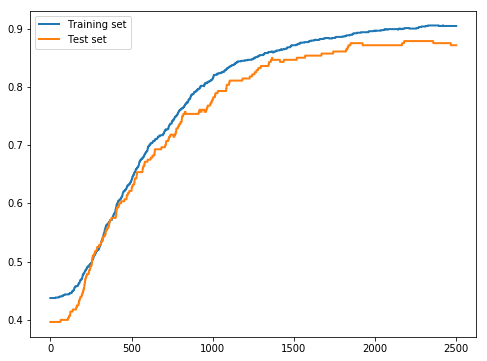

In [7]:
fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)
subplot.plot(range(len(train_accuracy)), train_accuracy,
             linewidth=2, label='Training set')
subplot.plot(range(len(test_accuracy)), test_accuracy,
             linewidth=2, label='Test set')
subplot.legend(loc='upper left')